# Set up
---

## Install libraries

In [ ]:
!pip install transformers
!pip install iterative-stratification
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [ ]:
import librosa
from transformers import Wav2Vec2Model,AutoProcessor,AutoTokenizer,AutoModel,utils
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import torch
import os
import pandas as pd
from google.colab import drive
import numpy as np

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import ParameterGrid

from tabulate import tabulate
import math

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datetime import datetime
import pytz

import pdb
import re

#from bertviz import model_view
utils.logging.set_verbosity_error()
pd.options.mode.chained_assignment = None

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

## Connect drive and select device

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Text transformations
---

## Dataset

In [ ]:
class DWDataset(torch.utils.data.Dataset):
    """
    A PyTorch dataset for sentiment analysis.

    Args:
        data (pandas.DataFrame): The input data.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for tokenizing the text data.

    Attributes:
        data (pandas.DataFrame): The input data.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for tokenizing the text data.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(index): Returns a single sample from the dataset.
    """

    def __init__(self, data, tokenizer,n_tokens,model=None):
        self.data = data.reset_index(drop=True).reset_index().rename(columns={"index":"id"})
        self.tokenizer = tokenizer
        self.data_labels= self.data['PHQ8_Binary'].values
        self.model = model
        self.n_tokens = n_tokens
        #self.embeddings = self.compute_embeddings()

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """

        return len(self.data)

    def compute_embeddings(self):

        embeds = {}
        for idd in tqdm(self.data.id.values):

          text = self.data.loc[self.data.id == idd]['intervention'].values[0]

          tokens = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.n_tokens, return_tensors='pt')

          input_ids = tokens["input_ids"].to("cuda")
          attention_mask =  tokens['attention_mask'].to("cuda")
          # Obtain embeddings
          with torch.no_grad():
              outputs = self.model(input_ids,attention_mask)
              sequence_embedding = outputs.last_hidden_state.squeeze(0)


          embeds.setdefault(idd,sequence_embedding)

        return embeds

    def __getitem__(self, index):
        """
        Returns a single sample from the dataset.

        Args:
            index (int): The index of the sample to return.

        Returns:
            dict: A dictionary containing the input IDs, attention mask, and label, patient_id and id.
        """

        label = self.data.iloc[index]['PHQ8_Binary']
        patient_id = self.data.iloc[index]['patient_id']
        #embeddings = self.embeddings[index]
        text = self.data.iloc[index]['intervention']
        tokens = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.n_tokens, return_tensors='pt')

        input_ids = tokens["input_ids"]
        attention_mask =  tokens['attention_mask']

        return {"input_ids": input_ids.squeeze(0),
                'attention_mask':attention_mask.squeeze(0),
                'label': torch.tensor(label),
                'patient_id':patient_id,
                "id":index}

## Utils

### Split function

In [ ]:
def split_dataset(df, test_size=0.15, val_size=0.2, random_state=42):
    """
  Function that splits a df taking in consideration balancing o Gender, PHQ and length of intervention.

  Params
  ---
    -df: The data to split
    -test_size: the size of the test set
    -val_size: the size of the validation set out of the remaining set after extracting the test set.
    -random_state: The seed, for reproducibility

  Returns
  ---
    - The same dataframe with a column name 'split' that indicates where each data point corresponds

  """
    # Ensure the 'gender' column is numerical
    if df['Gender'].dtype == 'object':
        df['Gender'] = df['Gender'].astype('category').cat.codes

    # Combine the 'gender' and 'label' columns into a new 2D array
    y = df[['Gender', 'PHQ8_Binary']].values


    try:
      # Split the DataFrame into three equal parts representing short, medium, and long texts
      labels=['short', 'medium', 'long']
      df['text_length_category'] = pd.qcut(df['word_count'], 3, labels=labels)
    except:
      labels=['short', 'long']
      # Split into 'short' and 'long' based on the median
      median = df['word_count'].median()
      df['text_length_category'] = np.where(df['word_count'] <= median, 'short', 'long')


    df_result = pd.DataFrame()

    # Loop over each category
    for category in labels:
        df_temp = df[df['text_length_category'] == category]

        # Create the initial splitter
        initial_split = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        # Split out the test set
        for other_index, test_index in initial_split.split(df_temp, df_temp[['Gender', 'PHQ8_Binary']].values):
            df_other, df_test = df_temp.iloc[other_index], df_temp.iloc[test_index]

        # Now create a new splitter for splitting the remaining data into train and validation sets
        train_val_split = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)

        y_other = df_other[['Gender', 'PHQ8_Binary']].values

        # Split the remaining data into train and validation sets
        for train_index, val_index in train_val_split.split(df_other, y_other):
            df_train, df_val = df_other.iloc[train_index], df_other.iloc[val_index]

        # Now assign labels to each set
        df_train['split'] = 'train'
        df_val['split'] = 'validation'
        df_test['split'] = 'test'

        df_temp = pd.concat([df_train, df_val, df_test])

        df_result = pd.concat([df_result, df_temp])

    return df_result


  ### Preprocess

In [ ]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import resample

def clean_text(text):
    cleaned_text = re.sub(r"\s+\.", ".", text)  # Remove the space before the period
    cleaned_text = re.sub(r"[^\w\s,.?!]", "", cleaned_text)  # Remove non-alphanumeric characters except for , . ? !
    return cleaned_text

def check_tokens(data):
  tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
  token_lengths = []
  for text in data.intervention.to_list():
      tokens = tokenizer.tokenize(text)
      token_lengths.append(len(tokens))

  length_df = pd.DataFrame({'Token Length': token_lengths})
  print(length_df.describe())

  return length_df


def drop_rows_below_percentile(df, column_name, percentile):
    # Step 1: Calculate the threshold number of words
    threshold = int(np.percentile(df[column_name].str.split().apply(len), percentile))

    # Step 2: Iterate over each row and count words
    word_counts = df[column_name].str.split().apply(len)

    # Step 3: Filter out rows below the threshold
    filtered_df = df[word_counts >= threshold].copy()

    return filtered_df

def preprocess_data(df):
    df.intervention = df.intervention.apply(lambda x: clean_text(x))
    df = split_dataset(df)
    #df = drop_rows_below_percentile(df,"intervention",10)

    return df.rename(columns={"id":"patient_id"})


def inverse_frequency(df):
  neg, pos = np.bincount(df["PHQ8_Binary"])
  total = neg + pos
  print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
      total, pos, 100 * pos / total))

  weight_for_0 = (1 / (neg / total))
  weight_for_1 = (1 / (pos / total))

  class_weight = {0: weight_for_0, 1: weight_for_1}

  #initial_bias = np.log([pos/neg])

  return class_weight

## Random oversampling

In [ ]:
def random_oversample(df,seed):
  # Separate the data based on class (assuming 'label' is the class column)
  # with 1 being the positive (minority) class
  df_minority = df[df['PHQ8_Binary'] == 1]
  df_majority = df[df['PHQ8_Binary'] == 0]

  # Perform oversampling on the minority class
  df_minority_oversampled = resample(df_minority,
                                      replace=True, # sample with replacement
                                      n_samples=int(len(df_majority)*0.95), # match number in majority class
                                      random_state=seed) # reproducible results

  # Combine the majority class with the oversampled minority class
  df_oversampled = pd.concat([df_majority, df_minority_oversampled])

  return df_oversampled

# Training functionalities
---

## Early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=True, delta=0.0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_max = -np.Inf
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_f1, val_loss, model, train_dict, val_dict):
        score = val_f1

        if self.best_score is None:
            self.best_score = score
            self.best_train_dict = train_dict
            self.best_val_dict = val_dict
            self.save_checkpoint(val_f1, model)
        elif score > self.best_score:
            self.best_score = score
            self.best_train_dict = train_dict
            self.best_val_dict = val_dict
            self.save_checkpoint(val_f1, model)
            self.counter = 0
        elif val_loss > self.val_loss_min + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.val_loss_min = val_loss
            self.counter = 0

    def save_checkpoint(self, val_f1, model):
        if self.verbose:
            print(f'Validation F1 increased ({self.val_f1_max:.6f} --> {val_f1:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_f1_max = val_f1


## Experiment


In [ ]:
class Experiment:
  """
  Class that will capitalize the inference process.
  """
  def __init__(self,model,criterion,optimizer,scheduler,early_stopper,writer):
    self.criterion = criterion
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.early_stopping = early_stopper
    self.model = model
    self.tb = writer

  def fit(self,num_epochs,train_data,val_data,verbose=0):

    self.train_loss = []
    self.val_loss = []

    for epoch in range(num_epochs):
       if verbose==1:
        print(f"\n--- Epoch {epoch+1} ---")

       train_dict = self.loop(train_data,self.optimizer,self.criterion,epoch,is_train=True)
       val_dict = self.loop(val_data,self.optimizer,self.criterion,epoch,is_train=False)


       self.train_loss.append(train_dict["loss"])
       self.val_loss.append(val_dict["loss"])


       self.track_metrics(train_dict,epoch,"train")
       self.track_metrics(val_dict,epoch,"validation")

       self.scheduler.step()

       if verbose == 1:
        self.print_metrics(train_dict,"Train")
        self.print_metrics(val_dict,"Validation")

       current_F1 = self.get_metrics(val_dict)["F1"]

       self.early_stopping(current_F1,self.val_loss[-1], self.model, train_dict, val_dict)
       if self.early_stopping.early_stop:
          print(f"Early stopping: detected overfitting on validation loss")
          break



    self.best_train_metrics = self.get_metrics(self.early_stopping.best_train_dict)
    self.best_val_metrics = self.get_metrics(self.early_stopping.best_val_dict)

    self.best_val_probs = self.early_stopping.best_val_dict["probs"]

    if verbose == 2:
      #self.print_metrics(train_dict,"Train")
      self.print_metrics(self.early_stopping.best_val_dict,"Validation")


  def loop(self, data_loader, optimizer, criterion, epoch, is_train):

    if is_train:
        self.model.train()
        progress_desc = 'Train'
    else:
        self.model.eval()
        progress_desc = 'Validation'

    progress_bar = tqdm(data_loader,
                        desc=f'{progress_desc} Epoch {epoch+1}',
                        leave=False,
                        disable=False)

    running_loss = 0.0
    total_samples = 0
    running_tp = 0
    running_tn = 0
    running_fp = 0
    running_fn = 0
    preds_auc = []
    labels_auc = []
    ids = []


    # Include the entire loop under either the no_grad context (if not training)
    # or the default context (if training)
    with torch.set_grad_enabled(is_train):
        for data in progress_bar:
            input_ids,attention_mask, labels, patient_id = data['input_ids'].to(device), data['attention_mask'].to(device),data["label"].to(device), data["patient_id"]

            if is_train:
                optimizer.zero_grad()

            outputs = self.model(input_ids,attention_mask).logits
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, 1)
            loss = criterion(outputs, labels)

            if is_train:
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * input_ids.size(0)
            running_tp += torch.sum((labels == 1) & (preds == 1))
            running_tn += torch.sum((labels == 0) & (preds == 0))
            running_fp += torch.sum((labels == 0) & (preds == 1))
            running_fn += torch.sum((labels == 1) & (preds == 0))

            ids += patient_id.detach().numpy().tolist()
            labels_auc += labels.cpu().detach().numpy().tolist()
            preds_auc += probabilities[:,1].cpu().detach().numpy().tolist()
            total_samples += input_ids.size(0)

    auc = roc_auc_score(labels_auc, preds_auc)

    total_samples = running_tn + running_tp +  running_fn + running_fp

    epoch_dict = {"loss":running_loss/total_samples,"probs": self.get_probs_dataframe(preds_auc,ids),
                  "tp":running_tp, "tn":running_tn, "fp":running_fp, "fn":running_fn,
                  "auc":auc}

    return epoch_dict


  def get_metrics(self, epoch_dict):
      tp = epoch_dict["tp"].item()
      fp = epoch_dict["fp"].item()
      tn = epoch_dict["tn"].item()
      fn = epoch_dict["fn"].item()
      loss = epoch_dict["loss"].item()
      auc = epoch_dict["auc"]

      total_samples = tp + fp + tn + fn
      acc = (tp + tn) / total_samples
      precision = tp / (tp + fp) if tp + fp > 0. else 0.
      recall = tp / (tp + fn) if tp + fn > 0. else 0.
      specificity = tn / (tn + fp) if tn + fp > 0 else 0
      F1 = 2 * (precision * recall) / (precision + recall) if precision+recall > 0. else 0.
      b_accuracy = (recall + specificity) / 2

      metrics_dict = {
          "tp": tp,
          "fp": fp,
          "tn": tn,
          "fn": fn,
          "loss": loss,
          "auc": auc,
          "accuracy": acc,
          "precision": precision,
          "recall": recall,
          "specificity": specificity,
          "F1": F1,
          "balanced_accuracy": b_accuracy,
      }

      return metrics_dict

  def print_metrics(self,epoch_dict,pl):
    metrics = self.get_metrics(epoch_dict)

    tp = metrics["tp"]
    fp = metrics["fp"]
    tn = metrics["tn"]
    fn = metrics["fn"]
    loss = metrics["loss"]
    auc = metrics["auc"]
    acc = metrics["accuracy"]
    recall = metrics["recall"]
    specificity = metrics["specificity"]
    F1 = metrics["F1"]
    b_accuracy = metrics["balanced_accuracy"]



    metrics_data = [
      ["Loss",        f"{loss:.3f}"       , "TP", f"{tp:.1f}"],
      ["Accuracy",    f"{acc:.3f}"        , "FP", f"{fp:.1f}"],
      ["F1 Score",    f"{F1:.3f}"         , "TN", f"{tn:.1f}"],
      ["Sensitivity", f"{recall:.3f}"     , "FN", f"{fn:.1f}"],
      ["Specificity", f"{specificity:.3f}", ""  , ""],
      ["Balanced Acc",f"{b_accuracy:.3f}" , ""  , ""],
      ["AUC",         f"{auc:.3f}"        , ""  , ""],
    ]


    print(f"\n{pl} Metrics Report")
    print(tabulate(metrics_data, headers=["Metric", "Value", "Metric", "Value"], tablefmt='pretty'))


  def track_metrics(self,epoch_dict,epoch,pl):

    metrics = self.get_metrics(epoch_dict)

    tp = metrics["tp"]
    fp = metrics["fp"]
    tn = metrics["tn"]
    fn = metrics["fn"]
    loss = metrics["loss"]
    auc = metrics["auc"]
    acc = metrics["accuracy"]
    recall = metrics["recall"]
    specificity = metrics["specificity"]
    F1 = metrics["F1"]
    b_accuracy = metrics["balanced_accuracy"]

    self.tb.add_scalar(f"Loss/{pl}", loss, epoch)
    self.tb.add_scalar(f"Accuracy/{pl}", acc, epoch)
    self.tb.add_scalar(f"F1-Score/{pl}", F1, epoch)
    self.tb.add_scalar(f"Sensibility/{pl}", recall, epoch)
    self.tb.add_scalar(f"Specificity/{pl}", specificity, epoch)
    self.tb.add_scalar(f"tp/{pl}", tp, epoch)
    self.tb.add_scalar(f"fp/{pl}", fp, epoch)
    self.tb.add_scalar(f"tn/{pl}", tn, epoch)
    self.tb.add_scalar(f"fn/{pl}", fn, epoch)
    self.tb.add_scalar(f"AUC/{pl}", auc, epoch)
    self.tb.add_scalar(f"Balanced-Accuracy/{pl}", b_accuracy, epoch)



  def plot_loss(self):
    # Plot the metrics on the same chart
    plt.plot(self.train_loss, label='Training Loss')
    plt.plot(self.val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  def get_probs_dataframe(self,probs, ids):


    df = pd.DataFrame(data=list(zip(ids,probs)),columns=["id","probs"])

    return df

  def predict(self, dataset, cutoff=0.5):
      self.model.eval()
      preds = []
      labels = []
      probs_auc = []
      ids = []

      progress_bar = tqdm(dataset,
                      desc=f'Test',
                      leave=False,
                      disable=False)

      for datap in progress_bar:

          input_ids, attention_mask, lab, patient_id = datap['input_ids'].to(device), datap['attention_mask'].to(device), datap["label"].to(device),datap["patient_id"]

          outputs = self.model(input_ids, attention_mask).logits

          probabilities = torch.nn.functional.softmax(outputs, dim=1)
          _, predis = torch.max(probabilities, 1)

          preds.append(predis)
          probs_auc.append(probabilities[:,1])
          labels.append(lab)
          ids.append(patient_id)

      preds = torch.stack(preds).cpu().numpy()
      labels = torch.stack(labels).cpu().numpy()
      probs_auc = torch.stack(probs_auc).cpu().detach().numpy()
      ids  = torch.stack(ids).detach().numpy()

      corrects = np.sum(preds == labels)
      tp = np.sum((labels == 1) & ((probs_auc >= cutoff) == 1))
      tn = np.sum((labels == 0) & ((probs_auc >= cutoff) == 0))
      fp = np.sum((labels == 0) & ((probs_auc >= cutoff) == 1))
      fn = np.sum((labels == 1) & ((probs_auc >= cutoff) == 0))

      auc = roc_auc_score(labels,probs_auc)

      epoch_test = {"loss":torch.tensor(0),"probs": self.get_probs_dataframe(probs_auc.flatten(),ids.flatten()),
                    "tp":torch.tensor(tp), "tn":torch.tensor(tn), "fp":torch.tensor(fp), "fn":torch.tensor(fn),
                    "auc":auc}

      self.test_probs = self.get_probs_dataframe(probs_auc.flatten(),ids.flatten())
      self.test_dict = self.get_metrics(epoch_test)
      self.print_metrics(epoch_dict=epoch_test,pl="Test")
      return preds, labels, self.test_dict


## Evaluation functions

In [ ]:
def create_metrics_dataframe_cv(experiments,dtst):
    metrics_dicts = []

    for i, exp in enumerate(experiments):
      if dtst == "val":
        metrics = exp.best_val_metrics.copy()
      else:
        metrics = exp.test_dict.copy()

      metrics['fold'] = i + 1
      metrics_dicts.append(metrics)


    df = pd.DataFrame(metrics_dicts)
    df.set_index('fold', inplace=True)

    summary_dict = {}
    for column in df.columns:
        summary_dict[column] = {
            'mean': df[column].mean(),
            'std': df[column].std()
        }

    summary_df = pd.DataFrame(summary_dict)

    # Concatenate the dataframes along the row axis (i.e., add the summary dataframe as new rows)
    full_df = pd.concat([df, summary_df], axis=0)

    # Apply a formatting function to each numeric value in the dataframe, to limit the number of decimal places
    full_df = full_df.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)


    return full_df

def get_predictions(question,experiments,t):
    probas_dicts = []

    for i, exp in enumerate(experiments):
      metrics = exp.best_val_probs if t == "val" else exp.test_probs
      probas_dicts.append(metrics.rename(columns={"probs":f"probs_model_{i}"}))

    df_merged = pd.DataFrame({'id': []})
    for df in probas_dicts:
      df_merged = df_merged.merge(df, on='id', how='outer')

    df_merged.to_csv(f'/content/gdrive/MyDrive/daiwoz/probas/roberta_{question}_{t}.csv')

    return df


# Cross-Validation
---

## 1 fold execution

In [ ]:
from transformers import AutoTokenizer, RobertaForSequenceClassification, BertForSequenceClassification

def one_fold(embed_model,train,val,test,batch_size,seed,params,writer,epochs,device):
  exps = []
  torch.manual_seed(seed)

  train_dataloader =  DataLoader(train, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test)

  criterion = nn.CrossEntropyLoss()

  stopper = EarlyStopping(patience=5)

  model = RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=2).to(device)

  # Freeze the layers, only leave the last dense layers
  for param in model.base_model.parameters():
    param.requires_grad = False


  optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'])

  # Create the learning rate scheduler.
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params["scheduler_step"], gamma=params["scheduler_gamma"])

  exp = Experiment(model,criterion,optimizer,scheduler,stopper,writer)
  exp.fit(epochs,train_dataloader,val_dataloader,verbose=2)
  exp.predict(test_dataloader)

  exps.append(exp)

  for ele in params:
    if isinstance(params[ele],list):
      params[ele] = ', '.join([str(item) for item in params[ele]])

  writer.add_hparams(params,exp.best_val_metrics)

  model.to("cpu")
  return exp


## AudiBert process

In [ ]:
def question_model_random(data,data_test,params,tokenizer,model,device,folds=5,epochs=20,batch_size=64,n_tokens=128):
  k = folds
  # Assume df is your DataFrame and 'label' is the column with the labels
  labels = data['PHQ8_Binary']
  # Create a StratifiedKFold object
  seed = 42

  model_id = datetime.now(pytz.timezone('Europe/Madrid')).strftime(f'%Y%m%d%_H%M')
  log_dir = f'/content/gdrive/MyDrive/daiwoz/runs/CV/BERT/{model_id}'
  writer = SummaryWriter(log_dir = log_dir)

  experiments = []
  datasets = []
  # Iterate over each fold
  train_df = data.loc[data.split=="train"].reset_index()
  valid_df = data.loc[data.split=="validation"].reset_index()

  train_df = random_oversample(train_df,seed)
  train_dataset = DWDataset(train_df, tokenizer,model=model,n_tokens=n_tokens)
  validation_dataset = DWDataset(valid_df,tokenizer,model=model,n_tokens=n_tokens)
  test_dataset = DWDataset(data_test,tokenizer,model=model,n_tokens=n_tokens)


  model_base = RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=2).to(device)
  initial_state = model_base.state_dict()
  torch.save(initial_state, 'initial_model_state.pth')
  for i in range(folds):
    # Print the sizes of the training and validation sets
    print(f"\n------ Fold {i + 1} --------")
    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(valid_df)}")
    model_base.load_state_dict(torch.load('initial_model_state.pth', map_location=device))

    fold_execution = one_fold(model_base,train_dataset,validation_dataset,test_dataset,batch_size,seed,params,writer,epochs,device)
    experiments.append(fold_execution)
    datasets.append((train_df,valid_df))

    torch.save(fold_execution.model, f"/content/gdrive/MyDrive/daiwoz/models2/TempBERT_gs_{model_id}_{i}.pth")

    seed+=1

  return experiments,datasets

  writer.flush()
  writer.close()

# Execution
---

## Load data

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/daiwoz/best_questions.csv",index_col=0).rename(columns={"value":"intervention"})

In [ ]:
data

,id,intervention,question,start_time,end_time,question_text,Gender,PHQ8_Score,PHQ8_Binary,split,word_count
0,300,good,0,62.328,63.178,how are you doing today,1,2,0,test,1
1,300,um probably about two weeks ago. uh frustrated...,1,227.998,267.988,when was the last time you argued with someone...,1,2,0,test,31
2,300,i'm i'm i'm pretty good at it um. yeah,2,217.728,222.068,how are you at controlling your temper,1,2,0,test,9
3,300,uh it's pretty easy. uh yes,4,430.858,437.598,how easy is it for you to get a good night's s...,1,2,0,test,6
4,300,no,5,470.658,471.348,have you been diagnosed with depression,1,2,0,test,1
...,...,...,...,...,...,...,...,...,...,...,...
2133,307,huh really happy oh when i was in mexico over ...,11,1163.838,1207.308,tell me about the last time you felt really happy,0,4,0,val,64
2134,308,mm it isn't yawn it isn't. yes it eh yes that ...,4,358.056,413.169,how easy is it for you to get a good night's s...,0,22,1,test,71
2135,308,yes. mm about three years ago four years ago c...,5,415.478,448.458,have you been diagnosed with depression,0,22,1,test,38
2136,308,uh loyal emotional strong that's it,8,752.232,766.762,how would your best friend describe you,0,22,1,test,6


In [ ]:
def iterate_over_all_questions(data):
  model = AutoModel.from_pretrained("bert-base-uncased")
  tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
  param_grid = {
    'learning_rate': 2e-3,
    'dataset': 'top15_questions',  # Replace with the names of your datasets.
    'scheduler_step': 11,
    'scheduler_gamma': 0.25,
    'pos_weight': 1
  }

  batch_size = 64
  scores = []
  models = []
  datasets = []

  loss_curves = []
  for value in data.question.unique():
    print(f"\n-------- Question {value} -------")
    question_data = preprocess_data(data.loc[data.question==value].dropna(axis=0))
    test_data = question_data.loc[question_data.split=="test"].reset_index()
    train_data = question_data.loc[question_data.split != "test"]

    exps,dts = question_model_random(train_data,test_data,param_grid,tokenizer,model,device,folds=3,batch_size=batch_size)


    eval = create_metrics_dataframe_cv(exps,"val")
    test = create_metrics_dataframe_cv(exps,"test")

    probas = get_predictions(value,exps,"val")
    probas_t = get_predictions(value,exps,"test")


    mean_f1_eval = eval.iloc[-2].F1
    std_f1_eval = eval.iloc[-1].F1

    mean_f1_test = test.iloc[-2].F1
    std_f1_test = test.iloc[-1].F1


    mean_auc_eval = eval.iloc[-2].auc
    std_auc_eval = eval.iloc[-1].auc

    mean_auc_test = test.iloc[-2].auc
    std_auc_test = test.iloc[-1].auc



    mean_recall_eval = eval.iloc[-2].recall
    std_recall_eval = eval.iloc[-1].recall

    mean_recall_test = test.iloc[-2].recall
    std_recall_test = test.iloc[-1].recall



    print(f"\nQuestion {value}: val F1: {mean_f1_eval} +/- {std_f1_eval} || test F1: {mean_f1_test} +/- {std_f1_test} ")

    scores.append((value,mean_f1_eval,std_f1_eval,
                   mean_auc_eval,std_auc_eval,
                   mean_recall_eval,std_recall_eval,
                   mean_f1_test,std_f1_test,
                   mean_auc_test,std_auc_eval,
                   mean_recall_test,std_recall_test
                   ))

    loss_curves.append([(exp.train_loss,exp.val_loss) for exp in exps])

    models.append(exps)
    datasets.append(dts)


  return pd.DataFrame(data = scores,columns=["question","V. F1"," V. F1 std",
                                             "V. auc","V. auc std",
                                             "V. recall","V. recall std",
                                             "T. F1","T. F1 std",
                                             "T. auc","T. auc std",
                                             "T. recall","T. recall std"]),models,datasets,loss_curves

## Start process

In [ ]:
results,models,datasets, loss_history = iterate_over_all_questions(data)
results


-------- Question 0 -------

------ Fold 1 --------
Training set size: 167
Validation set size: 32


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.476190).  Saving model ...


Validation F1 increased (0.476190 --> 0.533333).  Saving model ...


Validation F1 increased (0.533333 --> 0.588235).  Saving model ...


Validation F1 increased (0.588235 --> 0.636364).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.616 |   TP   |  7.0  |
|   Accuracy   | 0.750 |   FP   |  5.0  |
|   F1 Score   | 0.636 |   TN   | 17.0  |
| Sensitivity  | 0.700 |   FN   |  3.0  |
| Specificity  | 0.773 |        |       |
| Balanced Acc | 0.736 |        |       |
|     AUC      | 0.734 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.690 |   FP   |  7.0  |
|   F1 Score   | 0.571 |   TN   | 14.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.667 |        |       |
| Balanced Acc | 0.708 |        |       |
|     AUC      | 0.786 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 167
Validation set size: 32


Validation F1 increased (-inf --> 0.476190).  Saving model ...


Validation F1 increased (0.476190 --> 0.555556).  Saving model ...


Validation F1 increased (0.555556 --> 0.592593).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.656 |   TP   |  8.0  |
|   Accuracy   | 0.656 |   FP   |  9.0  |
|   F1 Score   | 0.593 |   TN   | 13.0  |
| Sensitivity  | 0.800 |   FN   |  2.0  |
| Specificity  | 0.591 |        |       |
| Balanced Acc | 0.695 |        |       |
|     AUC      | 0.757 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.690 |   FP   |  7.0  |
|   F1 Score   | 0.571 |   TN   | 14.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.667 |        |       |
| Balanced Acc | 0.708 |        |       |
|     AUC      | 0.780 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 167
Validation set size: 32


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.461538).  Saving model ...


Validation F1 increased (0.461538 --> 0.484848).  Saving model ...


Validation F1 increased (0.484848 --> 0.516129).  Saving model ...


Validation F1 increased (0.516129 --> 0.545455).  Saving model ...


Validation F1 increased (0.545455 --> 0.571429).  Saving model ...


Validation F1 increased (0.571429 --> 0.592593).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.648 |   TP   |  8.0  |
|   Accuracy   | 0.656 |   FP   |  9.0  |
|   F1 Score   | 0.593 |   TN   | 13.0  |
| Sensitivity  | 0.800 |   FN   |  2.0  |
| Specificity  | 0.591 |        |       |
| Balanced Acc | 0.695 |        |       |
|     AUC      | 0.689 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.724 |   FP   |  6.0  |
|   F1 Score   | 0.600 |   TN   | 15.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.714 |        |       |
| Balanced Acc | 0.732 |        |       |
|     AUC      | 0.792 |        |       |
+--------------+-------+--------+-------+

Question 0: val F1: 0.607 +/- 0.025 || test F1: 0.581 +/- 0.016 

-------- Question 1 -------

------ Fold 1 --------
Training set size: 165
Validation set size: 32


Validation F1 increased (-inf --> 0.466667).  Saving model ...


Validation F1 increased (0.466667 --> 0.476190).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.778 |   TP   | 10.0  |
|   Accuracy   | 0.312 |   FP   | 22.0  |
|   F1 Score   | 0.476 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.491 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.750 |   FP   |  0.0  |
|   F1 Score   | 0.222 |   TN   | 20.0  |
| Sensitivity  | 0.125 |   FN   |  7.0  |
| Specificity  | 1.000 |        |       |
| Balanced Acc | 0.562 |        |       |
|     AUC      | 0.513 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 165
Validation set size: 32


Validation F1 increased (-inf --> 0.476190).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.825 |   TP   | 10.0  |
|   Accuracy   | 0.312 |   FP   | 22.0  |
|   F1 Score   | 0.476 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.523 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.607 |   FP   |  5.0  |
|   F1 Score   | 0.267 |   TN   | 15.0  |
| Sensitivity  | 0.250 |   FN   |  6.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.619 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 165
Validation set size: 32


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.476190).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.762 |   TP   | 10.0  |
|   Accuracy   | 0.312 |   FP   | 22.0  |
|   F1 Score   | 0.476 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.414 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  0.0  |
|   Accuracy   | 0.714 |   FP   |  0.0  |
|   F1 Score   | 0.000 |   TN   | 20.0  |
| Sensitivity  | 0.000 |   FN   |  8.0  |
| Specificity  | 1.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.594 |        |       |
+--------------+-------+--------+-------+

Question 1: val F1: 0.476 +/- 0.000 || test F1: 0.163 +/- 0.143 

-------- Question 2 -------

------ Fold 1 --------
Training set size: 161
Validation set size: 30


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.413793).  Saving model ...


Validation F1 increased (0.413793 --> 0.437500).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.794 |   TP   |  7.0  |
|   Accuracy   | 0.400 |   FP   | 16.0  |
|   F1 Score   | 0.438 |   TN   |  5.0  |
| Sensitivity  | 0.778 |   FN   |  2.0  |
| Specificity  | 0.238 |        |       |
| Balanced Acc | 0.508 |        |       |
|     AUC      | 0.439 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.556 |   FP   |  9.0  |
|   F1 Score   | 0.500 |   TN   |  9.0  |
| Sensitivity  | 0.667 |   FN   |  3.0  |
| Specificity  | 0.500 |        |       |
| Balanced Acc | 0.583 |        |       |
|     AUC      | 0.525 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 161
Validation set size: 30


Validation F1 increased (-inf --> 0.461538).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.975 |   TP   |  9.0  |
|   Accuracy   | 0.300 |   FP   | 21.0  |
|   F1 Score   | 0.462 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.444 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  8.0  |
|   Accuracy   | 0.444 |   FP   | 14.0  |
|   F1 Score   | 0.516 |   TN   |  4.0  |
| Sensitivity  | 0.889 |   FN   |  1.0  |
| Specificity  | 0.222 |        |       |
| Balanced Acc | 0.556 |        |       |
|     AUC      | 0.679 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 161
Validation set size: 30


Validation F1 increased (-inf --> 0.461538).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.910 |   TP   |  9.0  |
|   Accuracy   | 0.300 |   FP   | 21.0  |
|   F1 Score   | 0.462 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.529 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.519 |   FP   |  7.0  |
|   F1 Score   | 0.316 |   TN   | 11.0  |
| Sensitivity  | 0.333 |   FN   |  6.0  |
| Specificity  | 0.611 |        |       |
| Balanced Acc | 0.472 |        |       |
|     AUC      | 0.451 |        |       |
+--------------+-------+--------+-------+

Question 2: val F1: 0.454 +/- 0.014 || test F1: 0.444 +/- 0.111 

-------- Question 4 -------

------ Fold 1 --------
Training set size: 156
Validation set size: 30


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.518519).  Saving model ...


Validation F1 increased (0.518519 --> 0.555556).  Saving model ...


Validation F1 increased (0.555556 --> 0.571429).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.608 |   TP   |  6.0  |
|   Accuracy   | 0.700 |   FP   |  6.0  |
|   F1 Score   | 0.571 |   TN   | 15.0  |
| Sensitivity  | 0.667 |   FN   |  3.0  |
| Specificity  | 0.714 |        |       |
| Balanced Acc | 0.690 |        |       |
|     AUC      | 0.683 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.786 |   FP   |  5.0  |
|   F1 Score   | 0.667 |   TN   | 16.0  |
| Sensitivity  | 0.857 |   FN   |  1.0  |
| Specificity  | 0.762 |        |       |
| Balanced Acc | 0.810 |        |       |
|     AUC      | 0.707 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 156
Validation set size: 30


Validation F1 increased (-inf --> 0.500000).  Saving model ...


Validation F1 increased (0.500000 --> 0.560000).  Saving model ...


Validation F1 increased (0.560000 --> 0.636364).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.603 |   TP   |  7.0  |
|   Accuracy   | 0.733 |   FP   |  6.0  |
|   F1 Score   | 0.636 |   TN   | 15.0  |
| Sensitivity  | 0.778 |   FN   |  2.0  |
| Specificity  | 0.714 |        |       |
| Balanced Acc | 0.746 |        |       |
|     AUC      | 0.683 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.750 |   FP   |  5.0  |
|   F1 Score   | 0.588 |   TN   | 16.0  |
| Sensitivity  | 0.714 |   FN   |  2.0  |
| Specificity  | 0.762 |        |       |
| Balanced Acc | 0.738 |        |       |
|     AUC      | 0.721 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 156
Validation set size: 30


Validation F1 increased (-inf --> 0.533333).  Saving model ...


Validation F1 increased (0.533333 --> 0.571429).  Saving model ...


Validation F1 increased (0.571429 --> 0.608696).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.625 |   TP   |  7.0  |
|   Accuracy   | 0.700 |   FP   |  7.0  |
|   F1 Score   | 0.609 |   TN   | 14.0  |
| Sensitivity  | 0.778 |   FN   |  2.0  |
| Specificity  | 0.667 |        |       |
| Balanced Acc | 0.722 |        |       |
|     AUC      | 0.693 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.786 |   FP   |  5.0  |
|   F1 Score   | 0.667 |   TN   | 16.0  |
| Sensitivity  | 0.857 |   FN   |  1.0  |
| Specificity  | 0.762 |        |       |
| Balanced Acc | 0.810 |        |       |
|     AUC      | 0.721 |        |       |
+--------------+-------+--------+-------+

Question 4: val F1: 0.605 +/- 0.033 || test F1: 0.641 +/- 0.045 

-------- Question 5 -------

------ Fold 1 --------
Training set size: 163
Validation set size: 29


Validation F1 increased (-inf --> 0.526316).  Saving model ...


Validation F1 increased (0.526316 --> 0.545455).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.522 |   TP   |  3.0  |
|   Accuracy   | 0.828 |   FP   |  0.0  |
|   F1 Score   | 0.545 |   TN   | 21.0  |
| Sensitivity  | 0.375 |   FN   |  5.0  |
| Specificity  | 1.000 |        |       |
| Balanced Acc | 0.688 |        |       |
|     AUC      | 0.738 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.808 |   FP   |  4.0  |
|   F1 Score   | 0.667 |   TN   | 16.0  |
| Sensitivity  | 0.833 |   FN   |  1.0  |
| Specificity  | 0.800 |        |       |
| Balanced Acc | 0.817 |        |       |
|     AUC      | 0.779 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 163
Validation set size: 29


Validation F1 increased (-inf --> 0.526316).  Saving model ...


Validation F1 increased (0.526316 --> 0.600000).  Saving model ...


Validation F1 increased (0.600000 --> 0.631579).  Saving model ...



Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.520 |   TP   |  6.0  |
|   Accuracy   | 0.759 |   FP   |  5.0  |
|   F1 Score   | 0.632 |   TN   | 16.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.762 |        |       |
| Balanced Acc | 0.756 |        |       |
|     AUC      | 0.792 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.769 |   FP   |  5.0  |
|   F1 Score   | 0.625 |   TN   | 15.0  |
| Sensitivity  | 0.833 |   FN   |  1.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.792 |        |       |
|     AUC      | 0.771 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 163
Validation set size: 29


Validation F1 increased (-inf --> 0.526316).  Saving model ...


Validation F1 increased (0.526316 --> 0.600000).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.643 |   TP   |  6.0  |
|   Accuracy   | 0.724 |   FP   |  6.0  |
|   F1 Score   | 0.600 |   TN   | 15.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.714 |        |       |
| Balanced Acc | 0.732 |        |       |
|     AUC      | 0.768 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.808 |   FP   |  4.0  |
|   F1 Score   | 0.667 |   TN   | 16.0  |
| Sensitivity  | 0.833 |   FN   |  1.0  |
| Specificity  | 0.800 |        |       |
| Balanced Acc | 0.817 |        |       |
|     AUC      | 0.779 |        |       |
+--------------+-------+--------+-------+

Question 5: val F1: 0.592 +/- 0.044 || test F1: 0.653 +/- 0.024 

-------- Question 6 -------

------ Fold 1 --------
Training set size: 154
Validation set size: 29


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.181818).  Saving model ...


Validation F1 increased (0.181818 --> 0.473684).  Saving model ...


Validation F1 increased (0.473684 --> 0.500000).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.762 |   TP   |  9.0  |
|   Accuracy   | 0.379 |   FP   | 18.0  |
|   F1 Score   | 0.500 |   TN   |  2.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.100 |        |       |
| Balanced Acc | 0.550 |        |       |
|     AUC      | 0.564 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.692 |   FP   |  3.0  |
|   F1 Score   | 0.333 |   TN   | 16.0  |
| Sensitivity  | 0.286 |   FN   |  5.0  |
| Specificity  | 0.842 |        |       |
| Balanced Acc | 0.564 |        |       |
|     AUC      | 0.451 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 154
Validation set size: 29


Validation F1 increased (-inf --> 0.473684).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.814 |   TP   |  9.0  |
|   Accuracy   | 0.310 |   FP   | 20.0  |
|   F1 Score   | 0.474 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.631 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.692 |   FP   |  3.0  |
|   F1 Score   | 0.333 |   TN   | 16.0  |
| Sensitivity  | 0.286 |   FN   |  5.0  |
| Specificity  | 0.842 |        |       |
| Balanced Acc | 0.564 |        |       |
|     AUC      | 0.466 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 154
Validation set size: 29


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.473684).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.900 |   TP   |  9.0  |
|   Accuracy   | 0.310 |   FP   | 20.0  |
|   F1 Score   | 0.474 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.603 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.692 |   FP   |  3.0  |
|   F1 Score   | 0.333 |   TN   | 16.0  |
| Sensitivity  | 0.286 |   FN   |  5.0  |
| Specificity  | 0.842 |        |       |
| Balanced Acc | 0.564 |        |       |
|     AUC      | 0.459 |        |       |
+--------------+-------+--------+-------+

Question 6: val F1: 0.482 +/- 0.015 || test F1: 0.333 +/- 0.000 

-------- Question 7 -------

------ Fold 1 --------
Training set size: 144
Validation set size: 27


Validation F1 increased (-inf --> 0.500000).  Saving model ...


Validation F1 increased (0.500000 --> 0.538462).  Saving model ...


Validation F1 increased (0.538462 --> 0.560000).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.670 |   TP   |  7.0  |
|   Accuracy   | 0.593 |   FP   |  9.0  |
|   F1 Score   | 0.560 |   TN   |  9.0  |
| Sensitivity  | 0.778 |   FN   |  2.0  |
| Specificity  | 0.500 |        |       |
| Balanced Acc | 0.639 |        |       |
|     AUC      | 0.716 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.519 |   FP   | 10.0  |
|   F1 Score   | 0.435 |   TN   |  9.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.474 |        |       |
| Balanced Acc | 0.549 |        |       |
|     AUC      | 0.553 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 144
Validation set size: 27


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.560000).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.676 |   TP   |  7.0  |
|   Accuracy   | 0.593 |   FP   |  9.0  |
|   F1 Score   | 0.560 |   TN   |  9.0  |
| Sensitivity  | 0.778 |   FN   |  2.0  |
| Specificity  | 0.500 |        |       |
| Balanced Acc | 0.639 |        |       |
|     AUC      | 0.710 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.593 |   FP   |  9.0  |
|   F1 Score   | 0.522 |   TN   | 10.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.526 |        |       |
| Balanced Acc | 0.638 |        |       |
|     AUC      | 0.559 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 144
Validation set size: 27


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.500000).  Saving model ...


Validation F1 increased (0.500000 --> 0.526316).  Saving model ...


Validation F1 increased (0.526316 --> 0.551724).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.701 |   TP   |  8.0  |
|   Accuracy   | 0.519 |   FP   | 12.0  |
|   F1 Score   | 0.552 |   TN   |  6.0  |
| Sensitivity  | 0.889 |   FN   |  1.0  |
| Specificity  | 0.333 |        |       |
| Balanced Acc | 0.611 |        |       |
|     AUC      | 0.691 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.556 |   FP   | 10.0  |
|   F1 Score   | 0.500 |   TN   |  9.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.474 |        |       |
| Balanced Acc | 0.612 |        |       |
|     AUC      | 0.526 |        |       |
+--------------+-------+--------+-------+

Question 7: val F1: 0.557 +/- 0.005 || test F1: 0.486 +/- 0.045 

-------- Question 8 -------

------ Fold 1 --------
Training set size: 152
Validation set size: 28


Validation F1 increased (-inf --> 0.444444).  Saving model ...


Validation F1 increased (0.444444 --> 0.457143).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.794 |   TP   |  8.0  |
|   Accuracy   | 0.321 |   FP   | 19.0  |
|   F1 Score   | 0.457 |   TN   |  1.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.050 |        |       |
| Balanced Acc | 0.525 |        |       |
|     AUC      | 0.394 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.692 |   FP   |  2.0  |
|   F1 Score   | 0.200 |   TN   | 17.0  |
| Sensitivity  | 0.143 |   FN   |  6.0  |
| Specificity  | 0.895 |        |       |
| Balanced Acc | 0.519 |        |       |
|     AUC      | 0.398 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 152
Validation set size: 28


Validation F1 increased (-inf --> 0.444444).  Saving model ...


Validation F1 increased (0.444444 --> 0.457143).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.759 |   TP   |  8.0  |
|   Accuracy   | 0.321 |   FP   | 19.0  |
|   F1 Score   | 0.457 |   TN   |  1.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.050 |        |       |
| Balanced Acc | 0.525 |        |       |
|     AUC      | 0.444 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.538 |   FP   |  6.0  |
|   F1 Score   | 0.143 |   TN   | 13.0  |
| Sensitivity  | 0.143 |   FN   |  6.0  |
| Specificity  | 0.684 |        |       |
| Balanced Acc | 0.414 |        |       |
|     AUC      | 0.316 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 152
Validation set size: 28


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.133333).  Saving model ...


Validation F1 increased (0.133333 --> 0.357143).  Saving model ...


Validation F1 increased (0.357143 --> 0.400000).  Saving model ...


Validation F1 increased (0.400000 --> 0.400000).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.718 |   TP   |  5.0  |
|   Accuracy   | 0.464 |   FP   | 12.0  |
|   F1 Score   | 0.400 |   TN   |  8.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.400 |        |       |
| Balanced Acc | 0.512 |        |       |
|     AUC      | 0.425 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.462 |   FP   | 10.0  |
|   F1 Score   | 0.300 |   TN   |  9.0  |
| Sensitivity  | 0.429 |   FN   |  4.0  |
| Specificity  | 0.474 |        |       |
| Balanced Acc | 0.451 |        |       |
|     AUC      | 0.383 |        |       |
+--------------+-------+--------+-------+

Question 8: val F1: 0.438 +/- 0.033 || test F1: 0.214 +/- 0.080 

-------- Question 10 -------

------ Fold 1 --------
Training set size: 146
Validation set size: 27


Validation F1 increased (-inf --> 0.457143).  Saving model ...


Validation F1 increased (0.457143 --> 0.470588).  Saving model ...


Validation F1 increased (0.470588 --> 0.484848).  Saving model ...


Validation F1 increased (0.484848 --> 0.516129).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.738 |   TP   |  8.0  |
|   Accuracy   | 0.444 |   FP   | 15.0  |
|   F1 Score   | 0.516 |   TN   |  4.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.211 |        |       |
| Balanced Acc | 0.605 |        |       |
|     AUC      | 0.612 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  0.0  |
|   Accuracy   | 0.708 |   FP   |  0.0  |
|   F1 Score   | 0.000 |   TN   | 17.0  |
| Sensitivity  | 0.000 |   FN   |  7.0  |
| Specificity  | 1.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.437 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 146
Validation set size: 27


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.457143).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.835 |   TP   |  8.0  |
|   Accuracy   | 0.296 |   FP   | 19.0  |
|   F1 Score   | 0.457 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.441 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  0.0  |
|   Accuracy   | 0.667 |   FP   |  1.0  |
|   F1 Score   | 0.000 |   TN   | 16.0  |
| Sensitivity  | 0.000 |   FN   |  7.0  |
| Specificity  | 0.941 |        |       |
| Balanced Acc | 0.471 |        |       |
|     AUC      | 0.571 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 146
Validation set size: 27


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.457143).  Saving model ...


Validation F1 increased (0.457143 --> 0.484848).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.778 |   TP   |  8.0  |
|   Accuracy   | 0.370 |   FP   | 17.0  |
|   F1 Score   | 0.485 |   TN   |  2.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.105 |        |       |
| Balanced Acc | 0.553 |        |       |
|     AUC      | 0.559 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.583 |   FP   |  9.0  |
|   F1 Score   | 0.545 |   TN   |  8.0  |
| Sensitivity  | 0.857 |   FN   |  1.0  |
| Specificity  | 0.471 |        |       |
| Balanced Acc | 0.664 |        |       |
|     AUC      | 0.571 |        |       |
+--------------+-------+--------+-------+

Question 10: val F1: 0.486 +/- 0.030 || test F1: 0.182 +/- 0.315 

-------- Question 11 -------

------ Fold 1 --------
Training set size: 161
Validation set size: 32


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.476190).  Saving model ...


Validation F1 increased (0.476190 --> 0.487805).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.761 |   TP   | 10.0  |
|   Accuracy   | 0.344 |   FP   | 21.0  |
|   F1 Score   | 0.488 |   TN   |  1.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.045 |        |       |
| Balanced Acc | 0.523 |        |       |
|     AUC      | 0.532 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.500 |   FP   |  9.0  |
|   F1 Score   | 0.300 |   TN   | 11.0  |
| Sensitivity  | 0.375 |   FN   |  5.0  |
| Specificity  | 0.550 |        |       |
| Balanced Acc | 0.463 |        |       |
|     AUC      | 0.481 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 161
Validation set size: 32


Validation F1 increased (-inf --> 0.476190).  Saving model ...


Validation F1 increased (0.476190 --> 0.486486).  Saving model ...


Validation F1 increased (0.486486 --> 0.551724).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.697 |   TP   |  8.0  |
|   Accuracy   | 0.594 |   FP   | 11.0  |
|   F1 Score   | 0.552 |   TN   | 11.0  |
| Sensitivity  | 0.800 |   FN   |  2.0  |
| Specificity  | 0.500 |        |       |
| Balanced Acc | 0.650 |        |       |
|     AUC      | 0.605 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.536 |   FP   |  7.0  |
|   F1 Score   | 0.235 |   TN   | 13.0  |
| Sensitivity  | 0.250 |   FN   |  6.0  |
| Specificity  | 0.650 |        |       |
| Balanced Acc | 0.450 |        |       |
|     AUC      | 0.512 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 161
Validation set size: 32


Validation F1 increased (-inf --> 0.476190).  Saving model ...


Validation F1 increased (0.476190 --> 0.500000).  Saving model ...


Validation F1 increased (0.500000 --> 0.514286).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.723 |   TP   |  9.0  |
|   Accuracy   | 0.469 |   FP   | 16.0  |
|   F1 Score   | 0.514 |   TN   |  6.0  |
| Sensitivity  | 0.900 |   FN   |  1.0  |
| Specificity  | 0.273 |        |       |
| Balanced Acc | 0.586 |        |       |
|     AUC      | 0.591 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.464 |   FP   |  8.0  |
|   F1 Score   | 0.118 |   TN   | 12.0  |
| Sensitivity  | 0.125 |   FN   |  7.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.362 |        |       |
|     AUC      | 0.487 |        |       |
+--------------+-------+--------+-------+

Question 11: val F1: 0.518 +/- 0.032 || test F1: 0.218 +/- 0.092 

-------- Question 3 -------

------ Fold 1 --------
Training set size: 152
Validation set size: 30


Validation F1 increased (-inf --> 0.461538).  Saving model ...


Validation F1 increased (0.461538 --> 0.500000).  Saving model ...


Validation F1 increased (0.500000 --> 0.533333).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.621 |   TP   |  4.0  |
|   Accuracy   | 0.767 |   FP   |  2.0  |
|   F1 Score   | 0.533 |   TN   | 19.0  |
| Sensitivity  | 0.444 |   FN   |  5.0  |
| Specificity  | 0.905 |        |       |
| Balanced Acc | 0.675 |        |       |
|     AUC      | 0.524 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  4.0  |
|   Accuracy   | 0.714 |   FP   |  4.0  |
|   F1 Score   | 0.500 |   TN   | 16.0  |
| Sensitivity  | 0.500 |   FN   |  4.0  |
| Specificity  | 0.800 |        |       |
| Balanced Acc | 0.650 |        |       |
|     AUC      | 0.650 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 152
Validation set size: 30


Validation F1 increased (-inf --> 0.461538).  Saving model ...


Validation F1 increased (0.461538 --> 0.461538).  Saving model ...


Validation F1 increased (0.461538 --> 0.533333).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.619 |   TP   |  4.0  |
|   Accuracy   | 0.767 |   FP   |  2.0  |
|   F1 Score   | 0.533 |   TN   | 19.0  |
| Sensitivity  | 0.444 |   FN   |  5.0  |
| Specificity  | 0.905 |        |       |
| Balanced Acc | 0.675 |        |       |
|     AUC      | 0.556 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.714 |   FP   |  5.0  |
|   F1 Score   | 0.556 |   TN   | 15.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.688 |        |       |
|     AUC      | 0.688 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 152
Validation set size: 30


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.571429).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.604 |   TP   |  4.0  |
|   Accuracy   | 0.800 |   FP   |  1.0  |
|   F1 Score   | 0.571 |   TN   | 20.0  |
| Sensitivity  | 0.444 |   FN   |  5.0  |
| Specificity  | 0.952 |        |       |
| Balanced Acc | 0.698 |        |       |
|     AUC      | 0.556 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.607 |   FP   |  8.0  |
|   F1 Score   | 0.476 |   TN   | 12.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.613 |        |       |
|     AUC      | 0.644 |        |       |
+--------------+-------+--------+-------+

Question 3: val F1: 0.546 +/- 0.022 || test F1: 0.511 +/- 0.041 

-------- Question 9 -------

------ Fold 1 --------
Training set size: 142
Validation set size: 28


Validation F1 increased (-inf --> 0.444444).  Saving model ...


Validation F1 increased (0.444444 --> 0.480000).  Saving model ...


Validation F1 increased (0.480000 --> 0.518519).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.709 |   TP   |  7.0  |
|   Accuracy   | 0.536 |   FP   | 12.0  |
|   F1 Score   | 0.519 |   TN   |  8.0  |
| Sensitivity  | 0.875 |   FN   |  1.0  |
| Specificity  | 0.400 |        |       |
| Balanced Acc | 0.637 |        |       |
|     AUC      | 0.719 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.600 |   FP   |  8.0  |
|   F1 Score   | 0.500 |   TN   | 10.0  |
| Sensitivity  | 0.714 |   FN   |  2.0  |
| Specificity  | 0.556 |        |       |
| Balanced Acc | 0.635 |        |       |
|     AUC      | 0.722 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 142
Validation set size: 28


Validation F1 increased (-inf --> 0.444444).  Saving model ...


Validation F1 increased (0.444444 --> 0.470588).  Saving model ...


Validation F1 increased (0.470588 --> 0.533333).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.783 |   TP   |  8.0  |
|   Accuracy   | 0.500 |   FP   | 14.0  |
|   F1 Score   | 0.533 |   TN   |  6.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.300 |        |       |
| Balanced Acc | 0.650 |        |       |
|     AUC      | 0.694 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  4.0  |
|   Accuracy   | 0.680 |   FP   |  5.0  |
|   F1 Score   | 0.500 |   TN   | 13.0  |
| Sensitivity  | 0.571 |   FN   |  3.0  |
| Specificity  | 0.722 |        |       |
| Balanced Acc | 0.647 |        |       |
|     AUC      | 0.643 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 142
Validation set size: 28


Validation F1 increased (-inf --> 0.375000).  Saving model ...


Validation F1 increased (0.375000 --> 0.380952).  Saving model ...


Validation F1 increased (0.380952 --> 0.428571).  Saving model ...


Validation F1 increased (0.428571 --> 0.480000).  Saving model ...


Validation F1 increased (0.480000 --> 0.615385).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.567 |   TP   |  4.0  |
|   Accuracy   | 0.821 |   FP   |  1.0  |
|   F1 Score   | 0.615 |   TN   | 19.0  |
| Sensitivity  | 0.500 |   FN   |  4.0  |
| Specificity  | 0.950 |        |       |
| Balanced Acc | 0.725 |        |       |
|     AUC      | 0.712 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.760 |   FP   |  4.0  |
|   F1 Score   | 0.625 |   TN   | 14.0  |
| Sensitivity  | 0.714 |   FN   |  2.0  |
| Specificity  | 0.778 |        |       |
| Balanced Acc | 0.746 |        |       |
|     AUC      | 0.714 |        |       |
+--------------+-------+--------+-------+

Question 9: val F1: 0.556 +/- 0.052 || test F1: 0.542 +/- 0.072 

-------- Question 12 -------

------ Fold 1 --------
Training set size: 78
Validation set size: 18


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.615385).  Saving model ...


Validation F1 increased (0.615385 --> 0.640000).  Saving model ...


Validation F1 increased (0.640000 --> 0.695652).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.680 |   TP   |  8.0  |
|   Accuracy   | 0.611 |   FP   |  7.0  |
|   F1 Score   | 0.696 |   TN   |  3.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.300 |        |       |
| Balanced Acc | 0.650 |        |       |
|     AUC      | 0.713 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  0.0  |
|   Accuracy   | 0.647 |   FP   |  0.0  |
|   F1 Score   | 0.000 |   TN   | 11.0  |
| Sensitivity  | 0.000 |   FN   |  6.0  |
| Specificity  | 1.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.561 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 78
Validation set size: 18


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.526316).  Saving model ...


Validation F1 increased (0.526316 --> 0.625000).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.674 |   TP   |  5.0  |
|   Accuracy   | 0.667 |   FP   |  3.0  |
|   F1 Score   | 0.625 |   TN   |  7.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.700 |        |       |
| Balanced Acc | 0.662 |        |       |
|     AUC      | 0.613 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  0.0  |
|   Accuracy   | 0.647 |   FP   |  0.0  |
|   F1 Score   | 0.000 |   TN   | 11.0  |
| Sensitivity  | 0.000 |   FN   |  6.0  |
| Specificity  | 1.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.667 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 78
Validation set size: 18


Validation F1 increased (-inf --> 0.615385).  Saving model ...


Validation F1 increased (0.615385 --> 0.714286).  Saving model ...


Early stopping: detected overfitting on validation loss

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.678 |   TP   |  5.0  |
|   Accuracy   | 0.778 |   FP   |  1.0  |
|   F1 Score   | 0.714 |   TN   |  9.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.900 |        |       |
| Balanced Acc | 0.762 |        |       |
|     AUC      | 0.588 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  4.0  |
|   Accuracy   | 0.588 |   FP   |  5.0  |
|   F1 Score   | 0.533 |   TN   |  6.0  |
| Sensitivity  | 0.667 |   FN   |  2.0  |
| Specificity  | 0.545 |        |       |
| Balanced Acc | 0.606 |        |       |
|     AUC      | 0.682 |        |       |
+--------------+-------+--------+-------+

Question 12: val F1: 0.678 +/- 0.047 || test F1: 0.178 +/- 0.308 


,question,V. F1,V. F1 std,V. auc,V. auc std,V. recall,V. recall std,T. F1,T. F1 std,T. auc,T. auc std,T. recall,T. recall std
0,0,0.607,0.025,0.727,0.035,0.767,0.058,0.581,0.016,0.786,0.035,0.750,0.000
1,1,0.476,0.000,0.476,0.056,1.000,0.000,0.163,0.143,0.575,0.056,0.125,0.125
2,2,0.454,0.014,0.471,0.050,0.926,0.128,0.444,0.111,0.551,0.050,0.630,0.280
3,4,0.605,0.033,0.686,0.006,0.741,0.064,0.641,0.045,0.717,0.006,0.810,0.082
4,5,0.592,0.044,0.766,0.027,0.625,0.217,0.653,0.024,0.776,0.027,0.833,0.000
5,6,0.482,0.015,0.599,0.033,1.000,0.000,0.333,0.000,0.459,0.033,0.286,0.000
6,7,0.557,0.005,0.706,0.013,0.815,0.064,0.486,0.045,0.546,0.013,0.708,0.072
7,8,0.438,0.033,0.421,0.025,0.875,0.217,0.214,0.080,0.366,0.025,0.238,0.165
8,10,0.486,0.030,0.537,0.088,1.000,0.000,0.182,0.315,0.527,0.088,0.286,0.495
9,11,0.518,0.032,0.576,0.039,0.900,0.100,0.218,0.092,0.494,0.039,0.250,0.125


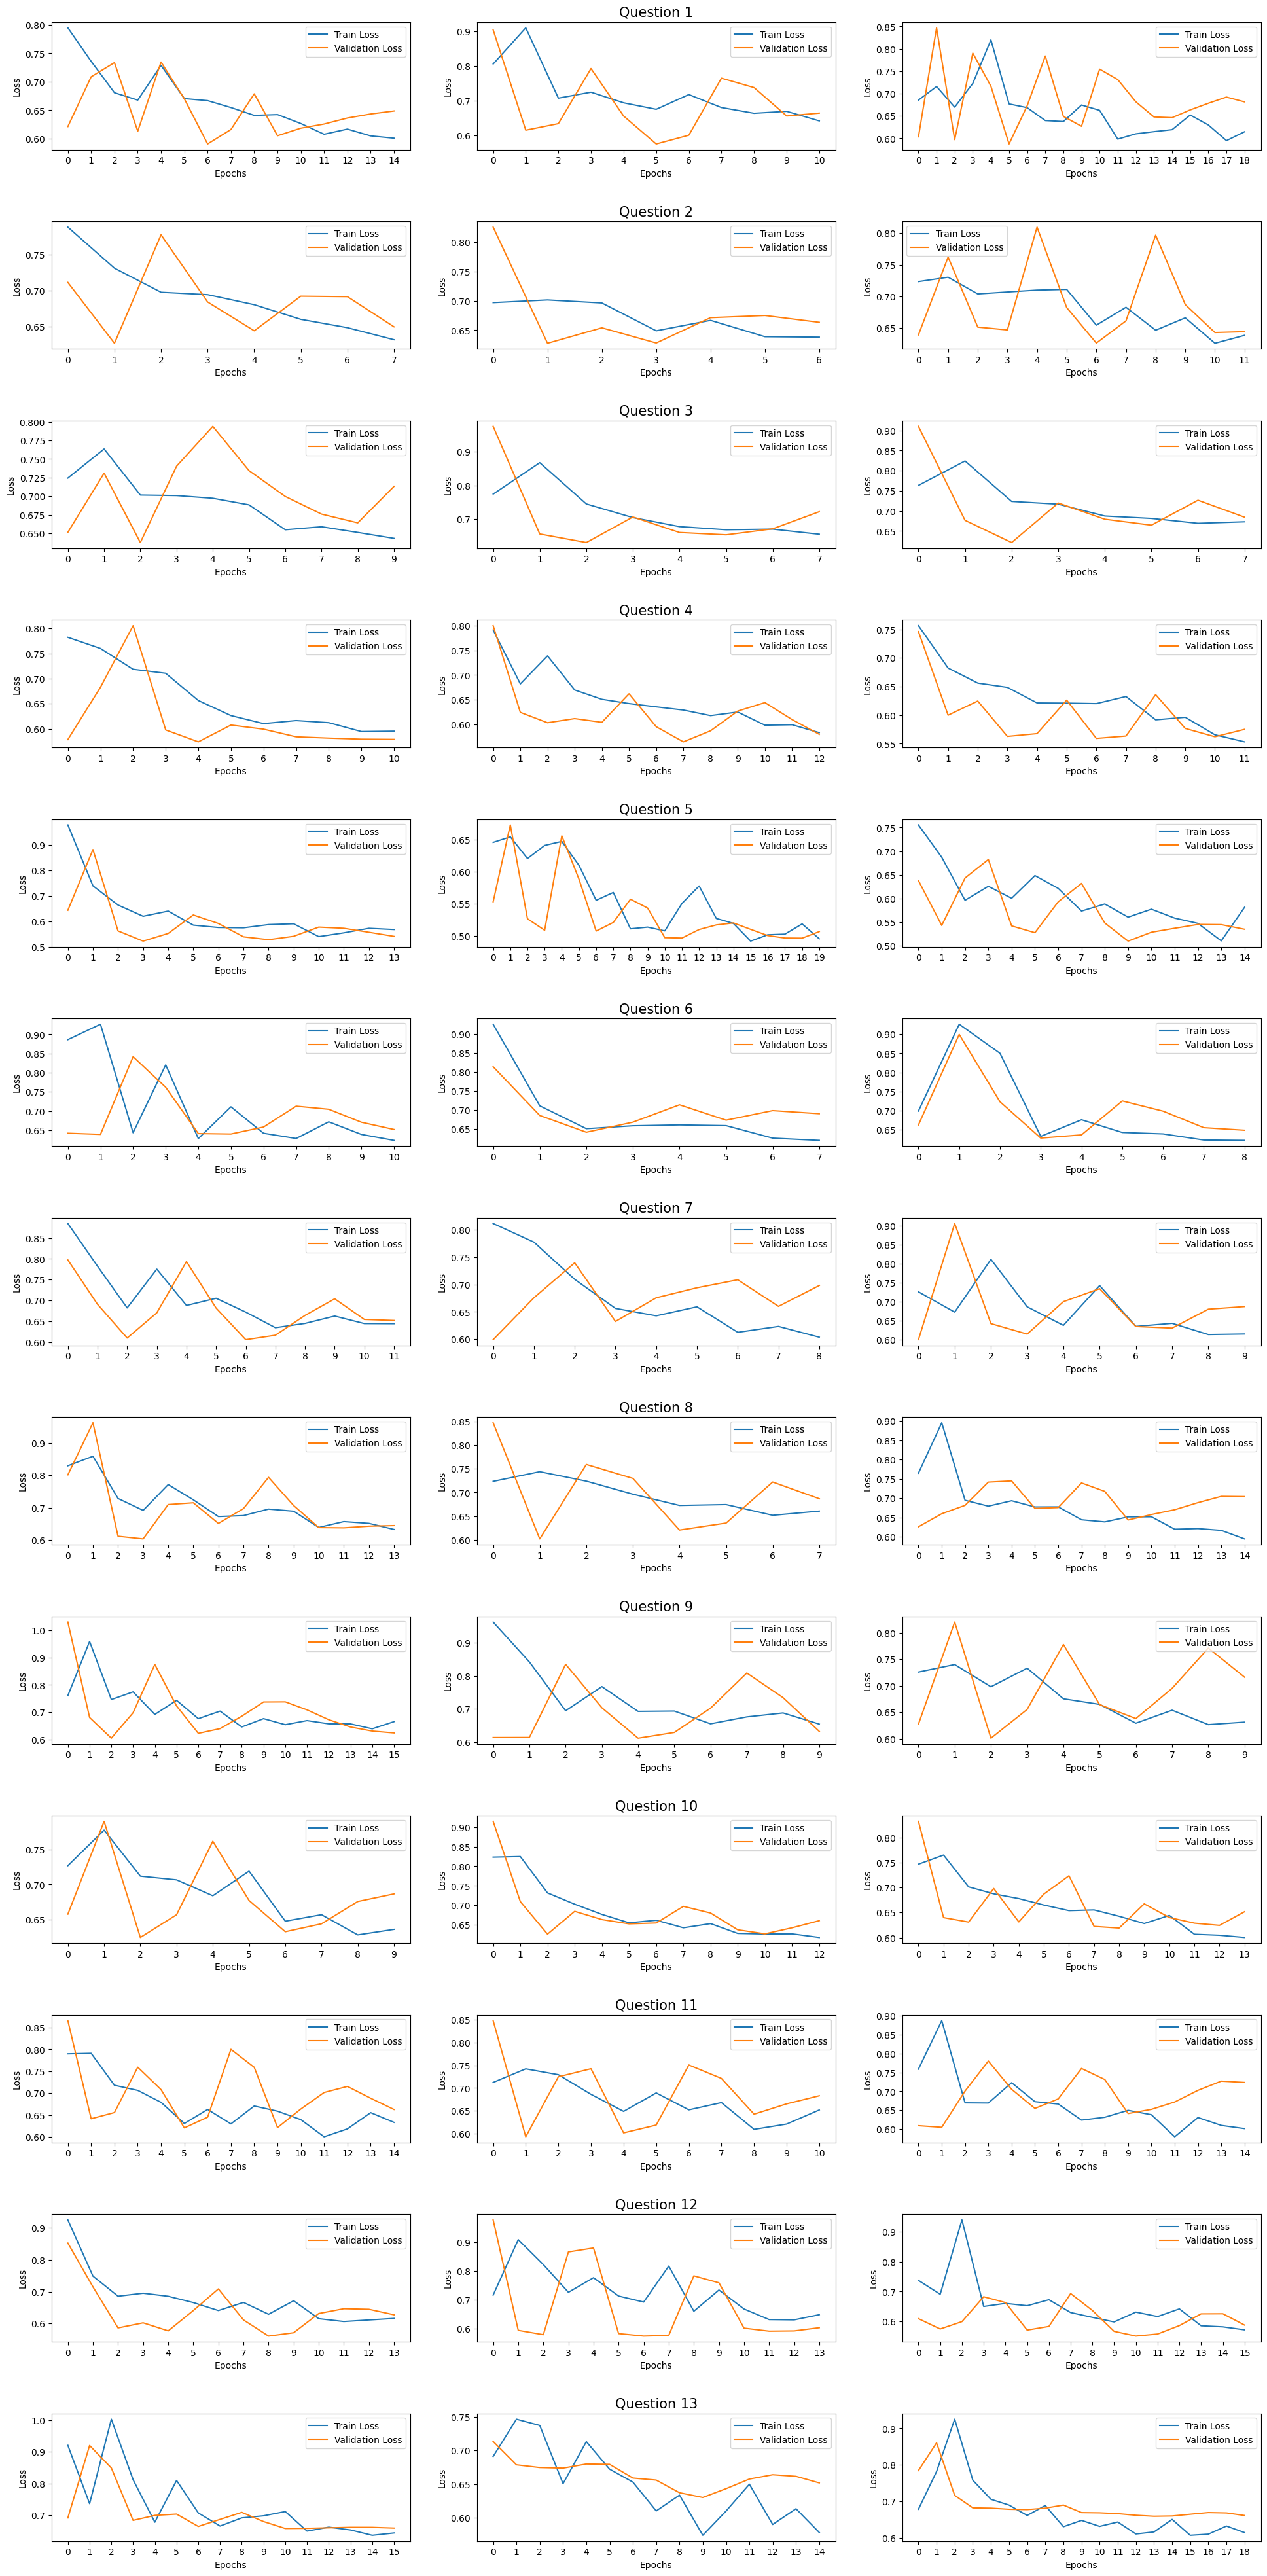

In [ ]:
import matplotlib.pyplot as plt

def plot_tuple_grid(data):
    # Create the figure and axes
    fig, axes = plt.subplots(nrows=len(data), ncols=3, figsize=(20, 40))

    # Iterate over the data and plot each tuple in the corresponding axes
    for i, tuple_data in enumerate(data):
        j = 0
        axes[i][1].set_title(f"Question {i+1}", fontsize=15)
        for tensor_list in tuple_data:
            ax = axes[i][j]

            # Plot the tensors using your desired plot function
            # For example, assuming each tensor list contains x and y coordinates:
            train = [tensor.cpu() for tensor in tensor_list[0]]
            val = [tensor.cpu() for tensor in tensor_list[1]]

            ax.plot(train, label="Train Loss")
            ax.plot(val, label="Validation Loss")

            # Set labels and legend
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.legend()

            num_epochs = len(train)
            x_ticks = range(num_epochs)
            ax.set_xticks(x_ticks)

            j += 1

    # Adjust spacing and layout
    fig.tight_layout(pad=3)

    # Show the plot
    plt.show()


plot_tuple_grid(loss_history)

In [ ]:
data[["question","question_text"]].drop_duplicates().merge(results,on="question").sort_values("question").reset_index(drop=True)

,question,question_text,V. F1,V. F1 std,V. auc,V. auc std,V. recall,V. recall std,T. F1,T. F1 std,T. auc,T. auc std,T. recall,T. recall std
0,0,how are you doing today,0.607,0.025,0.727,0.035,0.767,0.058,0.581,0.016,0.786,0.035,0.750,0.000
1,1,when was the last time you argued with someone...,0.476,0.000,0.476,0.056,1.000,0.000,0.163,0.143,0.575,0.056,0.125,0.125
2,2,how are you at controlling your temper,0.454,0.014,0.471,0.050,0.926,0.128,0.444,0.111,0.551,0.050,0.630,0.280
3,3,what are you most proud of in your life,0.546,0.022,0.545,0.018,0.444,0.000,0.511,0.041,0.660,0.018,0.583,0.072
4,4,how easy is it for you to get a good night's s...,0.605,0.033,0.686,0.006,0.741,0.064,0.641,0.045,0.717,0.006,0.810,0.082
5,5,have you been diagnosed with depression,0.592,0.044,0.766,0.027,0.625,0.217,0.653,0.024,0.776,0.027,0.833,0.000
6,6,have you ever been diagnosed with p_t_s_d,0.482,0.015,0.599,0.033,1.000,0.000,0.333,0.000,0.459,0.033,0.286,0.000
7,7,what did you study at school,0.557,0.005,0.706,0.013,0.815,0.064,0.486,0.045,0.546,0.013,0.708,0.072
8,8,how would your best friend describe you,0.438,0.033,0.421,0.025,0.875,0.217,0.214,0.080,0.366,0.025,0.238,0.165
9,9,how have you been feeling lately,0.556,0.052,0.708,0.013,0.792,0.260,0.542,0.072,0.693,0.013,0.667,0.082


In [ ]:
results.to_csv("/content/gdrive/MyDrive/daiwoz/Qresults/roberta_questions_final.csv")